 
 
   ----------------------------------------------------------
          Dartmouth AeOM ISOTOPOLOGUE KINETIC MODEL - SIMPLE         
   ----------------------------------------------------------
 

Number of time steps = 10000
k_rev/k =  0.0
T AeOM = 293.150 K

Opening AOM_kinetics_input.txt...
  Input file length =  10

INITIAL CONDITION VECTOR (moles)
0. 12CH4  out 	 = 6.427200e+02
1. 13CH4  out 	 = 6.938750e+00
2. 12CH3D out 	 = 3.387865e-01
3. 13CH3D out 	 = 3.667365e-03
4. 12CH2D2 out 	 = 6.746350e-05
5. 12CH3  out 	 = 0.000000e+00
6. 13CH3  out 	 = 0.000000e+00
7. 12CH2D out 	 = 0.000000e+00
8. 13CH2D out 	 = 0.000000e+00
9. 12CHD2 out 	 = 0.000000e+00
10. 12CH4   	 = 3.213600e+00
11. 13CH4   	 = 3.469375e-02
12. 12CH3D  	 = 1.693933e-03
13. 13CH3D  	 = 1.833682e-05
14. 12CH2D2 	 = 3.373175e-07
15. 12CH3   	 = 0.000000e+00
16. 13CH3   	 = 0.000000e+00
17. 12CH2D  	 = 0.000000e+00
18. 13CH2D  	 = 0.000000e+00
19. 12CHD2  	 = 0.000000e+00
20. H       	 = 0.000000e+00
21. D      

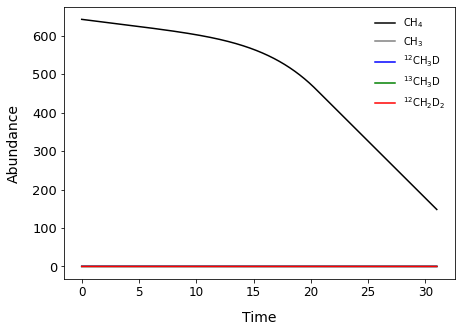

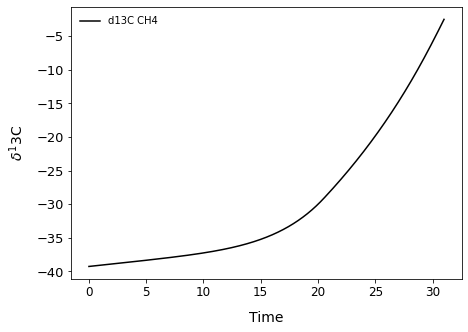

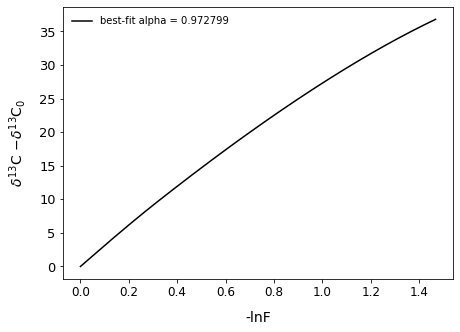

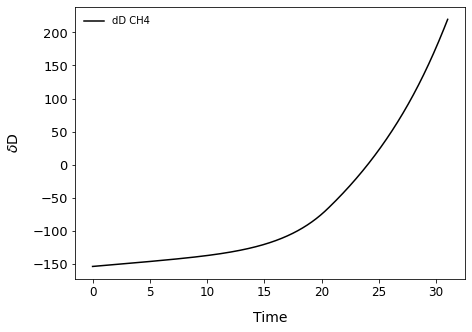

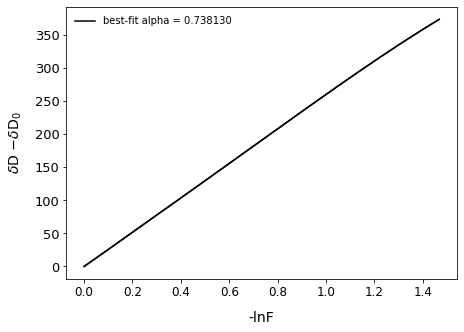

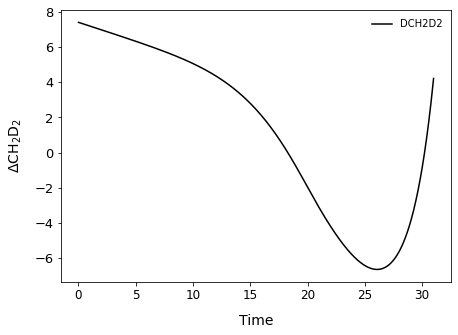

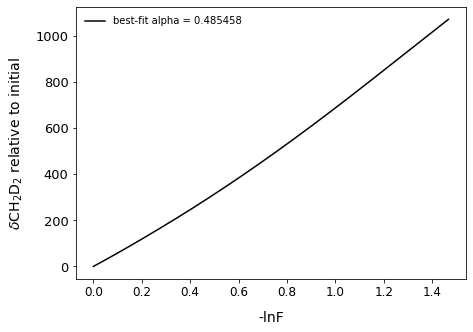

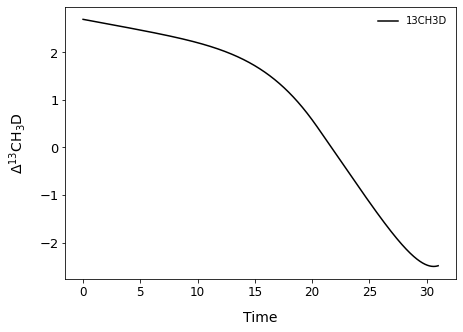

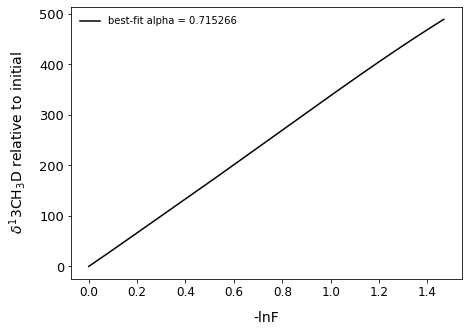

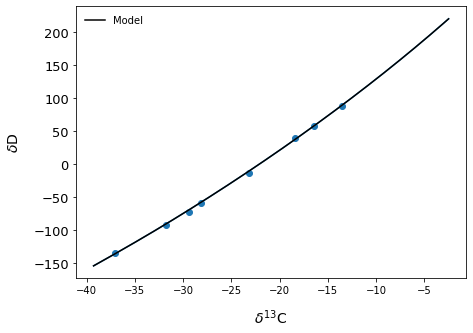

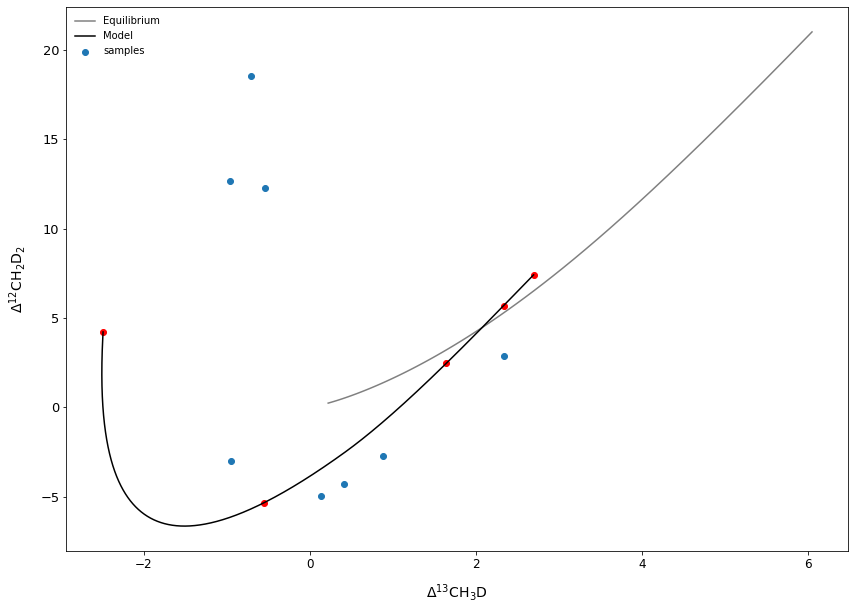


done



In [85]:
import matplotlib.pyplot as plt
import math as math
from math import sin as sin
from math import cos as cos
from math import asin as asin
from math import acos as acos
from math import sqrt as sqrt
import numpy as np
from numpy import log as ln
from numpy import log10 as log
from numpy import exp as exp
from scipy.integrate import solve_ivp
from scipy.stats import linregress
import scipy.special
import time


print(" ")
print(" ")
print("   ----------------------------------------------------------")
print("          Dartmouth AeOM ISOTOPOLOGUE KINETIC MODEL - SIMPLE         ")
print("   ----------------------------------------------------------")
print(" ")
#------------------------------------------------------------------------------------------------
#INPUTS
nmolec=650
num=10000  #number of time steps
#------------------------------------------------------------------------------------------------
# User defined parameters

reversible= False # Default as False for AeOM
factor= 0.0 #e.g., 5.0e-7, k_reverse rate constant relative to oxidation rate constant
t_lower=0.0001 # minimum time for time interval
t_upper= 31 # maximum time for time interval, dimensionless
# t=31, for 37C
# t= 210, for 27 C
# t= 508, for 21 C

Tkinetics=293.15 # 20 C, T for AeOM kinetics and re-equilibration in K
T=200.0 # Equilibration temperature of initial methane in C, OVERRIDEN BY INPUT FILE
TK=T+273.15 # Equilibration temperature of initial methane in K

output=True
s="v37_13"

# Experimentally defined fractionation factors
# 37 C

# Results from York Regression
a13=0.9671
aD=0.6967
aCD=0.6716
aDD=0.4309

# 27 C York Regression
# aD=0.7452
# a13=0.9713 
# aCD=0.7249
# aDD=0.5291

# 21 C
# a13=0.9757
# aD=0.7742
# aCD=0.7580
# aDD=0.5841

print('')
print('Number of time steps =',num)
print('k_rev/k = ',factor)
print('T AeOM = %.3f K' %Tkinetics)

# The FUNCTION for the right-hand-side of each ordinary differential equation is here.
# The values returned are the rates for each species Y_i.
#------------------------------------------------------------------------------------------------
# Define an error function to reproduce the trend
def errf(z,a,b,c,d):
    return a*scipy.special.erf(d*z-c)+b

# Define a transport flux
def dfdt(t,Y):
    # total CH4 in and out
    tCH4_out=sum(Y[0:4])
    tCH4_in=sum(Y[10:14])
    tr=t/t_upper # Relative timescale

# For 37 C
    Ko0=3.75/3.25
    Kom=30.0/3.25
    tc=0.66 # Change of total oxidation rate
    kD=0.355
    if tr<=tc:
        K_oxidize=Ko0+(Kom-Ko0)/tc**4*tr**4
    if tr>tc:
        K_oxidize=Kom
    Kin=kD*math.exp((-1/3)*(1.51524161*scipy.special.erf(3.66903692*tr-2.10590104)-1.98948754))*tCH4_out

# For 37 C, accounting for lag phase
#     Ko0=3.75/3.25
#     Kom=30.0/3.25
#     tc=0.66 # Change of total oxidation rate
#     tl=0.66 # Time of lag phase/early exponential
#     kD=0.355
#     if tr<=tc:
#         K_oxidize=Ko0+(Kom-Ko0)/tc**4*tr**4
#     if tr>tc:
#         K_oxidize=Kom
#     if tr<=tl:
#         Kin=kD*math.exp((-1/3)*(1.51524161*scipy.special.erf(3.66903692*tr-2.10590104)-1.98948754))*tCH4_out
#     if tr>tl:
#         if tr<=1.1*tl:
#             Kin=kD*math.exp((-1/3+1/(2*0.1)*(tr/tl-1))*(1.51524161*scipy.special.erf(3.66903692*tr-2.10590104)-1.98948754))*tCH4_out
#         if tr>1.1*tl:
#             Kin=kD*math.exp((1/6)*(1.51524161*scipy.special.erf(3.66903692*tr-2.10590104)-1.98948754))*tCH4_out

# For 27 C
#     Ko0=0.077/3.25
#     Kom=3.79/3.25
#     tc=0.46
#     kD=0.175
#     if tr<=tc:
#         K_oxidize=Ko0+(Kom-Ko0)/tc*tr
#     else:
#         K_oxidize=Kom
#     Kin=kD*math.exp((-1/3)*(-3.462*tr**3+3.9595*tr**2+2.0572*tr-3.4433))*tCH4_out

# For 27 C, accounting for lag phase
#     Ko0=0.077/3.25
#     Kom=3.79/3.25
#     tc=0.46
#     tl=0.46
#     kD=0.175
#     if tr<=tc:
#         K_oxidize=Ko0+(Kom-Ko0)/tc*tr
#     if tr>tc:
#         K_oxidize=Kom
#     if tr<=tl:
#         Kin=kD*math.exp((-1/3)*(-3.462*tr**3+3.9595*tr**2+2.0572*tr-3.4433))*tCH4_out
#     if tr>tl:
#         if tr<=1.1*tl:
#             Kin=kD*math.exp((-1/3+1/(2*0.1)*(tr/tl-1))*(-3.462*tr**3+3.9595*tr**2+2.0572*tr-3.4433))*tCH4_out
#         if tr>1.1*tl:
#             Kin=kD*math.exp((1/6)*(-3.462*tr**3+3.9595*tr**2+2.0572*tr-3.4433))*tCH4_out
        
# For 21 C
#     kD=0.1
#     K_oxidize=0.96/3.24
#     Kin=kD*math.exp((1/6)*(-0.4127*tr**3-2.1616*tr**2+4.9*tr-3.4983))*tCH4_out

# For sensitivity
#     K_oxidize=1.0
#     Kin=5
    
    K_synth=factor*K_oxidize
    K[0]=K_oxidize*Alpha[0]
    K[1]=1/4*K_oxidize*Alpha[1] #0.5*K_oxidize*Alpha[1]
    K[2]=3/4*K_oxidize*Alpha[2] #0.5*K_oxidize*Alpha[2]
    K[3]=0.5*K_oxidize*Alpha[3] #0.5*K_oxidize*Alpha[3]
    K[4]=0.5*K_oxidize*Alpha[4] #0.5*K_oxidize*Alpha[4]
    K[5]=K_oxidize*Alpha[5]     #K_oxidize*Alpha[5]
    K[6]=1/4*K_oxidize*Alpha[6] #0.5*K_oxidize*Alpha[6]
    K[7]=3/4*K_oxidize*Alpha[7] #0.5*K_oxidize*Alpha[7]
    K[8]=0.5*K_synth*Alpha[8] #0.5*K_synth*Alpha[8]
    K[9]=0.5*K_synth*Alpha[9] #0.5*K_synth*Alpha[9]
    K[10]=0.5*K_synth*Alpha[10]#(4.0/7.0)*K_synth*Alpha[10] #(4.0/7.0)*K_synth*Alpha[10]
    K[11]=0.5*K_synth*Alpha[11]#(3.0/7.0)*K_synth*Alpha[11] #(3.0/7.0)*K_synth*Alpha[11]  , complement to above
    K[12]=1.0*K_synth*Alpha[12]   #1.0*K_synth*Alpha[12]
    K[13]=0.5*K_synth*Alpha[13] #0.5*K_synth*Alpha[13]
    K[14]=0.5*K_synth*Alpha[14] #0.5*K_synth*Alpha[14]
    K[15]=1.0*K_synth*Alpha[15]     #K_synth*Alpha[15]
    
    Kt= K[0]*Y[10]+K[5]*Y[11]+K[2]*Y[12]+K[1]*Y[12]+K[6]*Y[13]+K[7]*Y[13]+K[3]*Y[14]+K[4]*Y[14] 
    # total methane oxidation inside the cell
    Kout=Kin-Kt # Kout to make the inner cell box at ss
    # Monitor total methane in and out
    if t==t_lower:
        print("")
        print("Outside methane: ", tCH4_out)
        print("Inside methane: ", tCH4_in)
        print("Total methane oxidation:", Kt)
        print("Transport flux in: ", Kin)
        print("Transport flux out: ", Kout)
        print("Actual Da:", Kt/Kin)
        print("k", Kin/tCH4_out)
        print("")
    
#     if t>=tc: 
#         if t<=tc+(t_upper-t_lower)/num:
#             print("")
#             print("Outside methane: ", tCH4_out)
#             print("Inside methane: ", tCH4_in)
#             print("Total methane oxidation:", Kt)
#             print("Transport flux in: ", Kin)
#             print("Transport flux out: ", Kout)
#             print("Da:", Kt/Kin)
#             print("")

    if t==t_upper:
        print("")
        print("Outside methane: ", tCH4_out)
        print("Inside methane: ", tCH4_in)
        print("Total methane oxidation:", Kt)
        print("Transport flux in: ", Kin)
        print("Transport flux out: ", Kout)
        print("Actual Da:", Kt/Kin)
        print("k", Kin/tCH4_out)
        print("")
        
    # print(Kt/K_oxidize)    
    # Check if Y is negative, if yes, print an error message 
    for i in Y:
        if i < 0:
            print("Error: methane concentration cannot be negative.")
            print(Y)
            print("Outside methane: ", tCH4_out)
            print("Inside methane: ", tCH4_in)
            print("Total methane oxidation:", Kt)
            print("Transport flux in: ", Kin)
            print("Transport flux out: ", Kout)
            print("")
        
    # ODE for outter box
    dYdt[0]=-Kin*Y[0]/tCH4_out+Kout*Y[10]/tCH4_in
    dYdt[1]=-Kin*Y[1]/tCH4_out+Kout*Y[11]/tCH4_in
    dYdt[2]=-Kin*Y[2]/tCH4_out+Kout*Y[12]/tCH4_in
    dYdt[3]=-Kin*Y[3]/tCH4_out+Kout*Y[13]/tCH4_in
    dYdt[4]=-Kin*Y[4]/tCH4_out+Kout*Y[14]/tCH4_in
#     dYdt[5]=-Kin*Y[5]+Kout*Y[15]
#     dYdt[6]=-Kin*Y[6]+Kout*Y[16]
#     dYdt[7]=-Kin*Y[7]+Kout*Y[17]
#     dYdt[8]=-Kin*Y[8]+Kout*Y[18]
#     dYdt[9]=-Kin*Y[9]+Kout*Y[19]
#     dYdt[10]=-Kin*Yout[10]+Kout*Yin[10] # Two hydrogen species are not transported
#     dYdt[11]=-Kin*Yout[11]+Kout*Yin[11]
    # ODE for inner box
    dYdt[10]=-K[0]*Y[10]+K[8]*Y[15]*Y[20]+Kin*Y[0]/tCH4_out-Kout*Y[10]/tCH4_in
    dYdt[11]=-K[5]*Y[11]+K[13]*Y[16]*Y[20]+Kin*Y[1]/tCH4_out-Kout*Y[11]/tCH4_in
    dYdt[12]=-K[2]*Y[12]-K[1]*Y[12]+K[10]*Y[17]*Y[20]+K[9]*Y[15]*Y[21]+Kin*Y[2]/tCH4_out-Kout*Y[12]/tCH4_in
    dYdt[13]=-K[6]*Y[13]-K[7]*Y[13]+K[14]*Y[16]*Y[21]+K[15]*Y[18]*Y[20]+Kin*Y[3]/tCH4_out-Kout*Y[13]/tCH4_in
    dYdt[14]=-K[3]*Y[14]-K[4]*Y[14]+K[11]*Y[17]*Y[21]+K[12]*Y[19]*Y[20]+Kin*Y[4]/tCH4_out-Kout*Y[14]/tCH4_in
    dYdt[15]=-K[8]*Y[15]*Y[20]-K[9]*Y[15]*Y[21]+K[0]*Y[10]+K[1]*Y[12] # +Kin*Y[5]-Kout*Y[15]
    dYdt[16]=-K[13]*Y[16]*Y[20]-K[14]*Y[16]*Y[21]+K[5]*Y[11]+K[6]*Y[13] # +Kin*Y[6]-Kout*Y[16]
    dYdt[17]=-K[10]*Y[17]*Y[20]-K[11]*Y[17]*Y[21]+K[2]*Y[12]+K[3]*Y[14] # +Kin*Y[7]-Kout*Y[17]
    dYdt[18]=-K[15]*Y[18]*Y[20]+K[7]*Y[13] # +Kin*Y[8]-Kout*Y[18]
    dYdt[19]=-K[12]*Y[19]*Y[20]+K[4]*Y[14] # +Kin*Y[9]-Kout*Y[19]
    dYdt[20]=-K[8]*Y[20]*Y[15]-K[10]*Y[20]*Y[17]-K[12]*Y[20]*Y[19]-K[13]*Y[20]*Y[16]-K[15]*Y[20]*Y[18] \
        +K[0]*Y[10]+K[2]*Y[12]+K[4]*Y[14]+K[5]*Y[11]+K[7]*Y[13]
    dYdt[21]=-K[9]*Y[21]*Y[15]-K[11]*Y[21]*Y[17]-K[14]*Y[21]*Y[16]+K[1]*Y[12]+K[3]*Y[14]+K[6]*Y[13]
    return dYdt

#INITIALIZE ARRAYS
dD_CH4_t=np.zeros(num)
d13C_CH4_t=np.zeros(num)
d13CH3D_t=np.zeros(num)
D13CH3D_t=np.zeros(num)
d12CH2D2_t=np.zeros(num)
D12CH2D2_t=np.zeros(num)
D_H_CH4=np.zeros(num)
C13_C12_CH4=np.zeros(num)
xH_CH4=np.zeros(num)
xD_CH4=np.zeros(num)
x12C_CH4=np.zeros(num)
x13C_CH4=np.zeros(num)

d13C_CH3_t=np.zeros(num)
dD_CH3_t=np.zeros(num)
xCH3_t=np.zeros(num)
xCH2D_t=np.zeros(num)
xCHD2_t=np.zeros(num)

# fractions of isotopologues, stochastic and equilibrium, for a single CH4 composition.
nCH4=10
xst_CH4=np.zeros(nCH4)
xeq_CH4=np.zeros(nCH4)
nCH3=6
xst_CH3=np.zeros(nCH3)
xeq_CH3=np.zeros(nCH3)

# Standard reference values
VSMOW=0.00015576
VPDB=0.0112372

# Isotopologue mole fraction names for all species
xnames=[
"12CH4",
"13CH4",
"12CH3D",
"13CH3D",
"12CH2D2",
"13CH2D2",
"12CHD3",
"13CHD3",
"12CD4",
"13CD4",
"12CH3",
"13CH3",
"12CH2D",
"13CH2D",
"12CHD2",
"13CHD2",
"H",
"D"]

# DEFINE FUNCTIONS FOR CALCULATING ISOTOPOLOUGE ABUNDANCES FOR CH4 AND CH3
#------------------------------------------------------------------------------------------------
def CH4_isotopologues(dD,d13C,TK):
# Calculates mole fractions of isotopologues of CH4 from input bulk isotope ratios
# for stochastic distribution and for a specified temperature TK in Kelvin.
# The order of isotopologue fractions, vector Y, is set here as well.
    VSMOW=0.00015576
    VPDB=0.0112372
    D_H=VSMOW*(dD/1000.0+1.0)
    C13_C12=VPDB*(d13C/1000.0+1.0)
    xH=1.0/(1.0+D_H)
    xD=D_H/(1.0+D_H)
    x12C=1.0/(1.0+C13_C12)      #x12C
    x13C=C13_C12/(1.0+C13_C12)  #x13C
    xst_CH4[0]=(xH**4)*x12C                 #x12CH4 =0
    xst_CH4[1]=(xH**4)*x13C                 #x13CH4 =1
    xst_CH4[2]=4.0*(xH**3)*xD*x12C          #x12CH3D =2
    xst_CH4[3]=4.0*(xH**3)*xD*x13C          #x13CH3D =3
    xst_CH4[4]=6.0*(xH**2)*(xD**2.0)*x12C   #x12CH2D2 =4
    xst_CH4[5]=6.0*(xH**2)*(xD**2.0)*x13C   #x13CH2D2 =5
    xst_CH4[6]=4.0*xH*(xD**3)*x12C          #x12CHD3 =6
    xst_CH4[7]=4.0*xH*(xD**3)*x13C          #x13CHD3 =7
    xst_CH4[8]=(xD**4)*x12C                 #x12CD4 =8
    xst_CH4[9]=(xD**4)*x13C                 #x13CD4 =9
    G5=1/TK
    alpha13D=1+0.03555020*G5-433.038*G5**2+1.27021e6*G5**3-5.94804e8*G5**4+1.19663e11*G5**5-9.0723e12*G5**6
    alphaD2=1+0.183798*G5-785.483*G5**2+1.056280e6*G5**3+9.37307e7*G5**4-8.91948e10*G5**5+9.90173e12*G5**6
    i=0
    while i < len(xst_CH4):
        xeq_CH4[i]=xst_CH4[i]
        i=i+1
    xeq_CH4[3]=xst_CH4[3]*alpha13D
    xeq_CH4[4]=xst_CH4[4]*alphaD2
    return xH,xD,x12C,x13C,xst_CH4,xeq_CH4,alpha13D,alphaD2
#------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------
def CH3_isotopologues(dD,d13C):
# Calculates mole fractions of isotopologues of CH3 from input bulk isotope ratios
# for stochastic distribution.
    VSMOW=0.00015576
    VPDB=0.0112372
    D_H=VSMOW*(dD/1000.0+1.0)
    C13_C12=VPDB*(d13C/1000.0+1.0)
    xH=1.0/(1.0+D_H)
    xD=D_H/(1.0+D_H)
    x12C=1.0/(1.0+C13_C12)      #x12C
    x13C=C13_C12/(1.0+C13_C12)  #x13C
    xst_CH3[0]=(xH**3)*x12C                 #x12CH3 =0
    xst_CH3[1]=(xH**3)*x13C                 #x13CH3 =1
    xst_CH3[2]=3.0*(xH**2)*xD*x12C          #x12CH2D =2
    xst_CH3[3]=3.0*(xH**2)*xD*x13C          #x13CH2D =3
    xst_CH3[4]=3.0*(xH)*(xD**2.0)*x12C      #x12CHD2 =4
    xst_CH3[5]=3.0*(xH)*(xD**2.0)*x13C      #x13CHD2 =5
    i=0
    while i < len(xst_CH3):
        xeq_CH3[i]=xst_CH3[i]
        i=i+1
    return xst_CH3,xeq_CH3
#------------------------------------------------------------------------------------------------
# INITIALIZE COMPOSITION OF METHANE

#READ composition of initial CH4 from file
print('')
print('Opening AOM_kinetics_input.txt...')
name="AOM_kinetics_input_37C.txt"
count = len(open(name).readlines())
print('  Input file length = ', count)
values=np.genfromtxt(name,'float')  # Read from file into values
ynames=[
"12CH4  ",
"13CH4  ",
"12CH3D ",
"13CH3D ",
"12CH2D2",
"12CH3  ",
"13CH3  ",
"12CH2D ",
"13CH2D ",
"12CHD2 ",
"H      ",
"D      "]
ny=len(ynames)
Y0=np.zeros(2*ny-2) # Assign zero to all initial abundances, Y0[0:9] are CH4 isotopologues in the outside box
# Y0[10:21] are CH4 isotopologues + H + D in the inside box
Yin=np.zeros(ny)
Yout=np.zeros(ny-2)
for i in range(0,5):
    Y0[i]=nmolec*values[i]  # Assign first 5 CH4 relative abundances to Y0, put arbitrary multiplier here
Y0[10:15]=0.005*Y0[0:5] # Assign 0.5 % of outer methane in the cell for reactions
# Calculate compositional parameters for input CH4
d13C_CH4=1000.0*((Y0[1]/Y0[0])/VPDB -1.0)
dD_CH4=1000.0*(((Y0[2]/Y0[0])/4.0)/VSMOW -1.0)
ratio_i_CH2D2_CH4=Y0[4]/Y0[0]
ratio_i_13CH3D_CH4=Y0[3]/Y0[0]
xH,xD,x12C,x13C,xst_CH4,xeq_CH4,alpha13D,alphaD2 = CH4_isotopologues(dD_CH4, d13C_CH4, TK)
D12CH2D2_CH4=1000.0*(ratio_i_CH2D2_CH4/(xst_CH4[4]/xst_CH4[0])-1.0)
D13CH3D_CH4=1000.0*(ratio_i_13CH3D_CH4/(xst_CH4[3]/xst_CH4[0])-1.0)

ynames=[
"12CH4  out",
"13CH4  out",
"12CH3D out",
"13CH3D out",
"12CH2D2 out",
"12CH3  out",
"13CH3  out",
"12CH2D out",
"13CH2D out",
"12CHD2 out",
"12CH4  ",
"13CH4  ",
"12CH3D ",
"13CH3D ",
"12CH2D2",
"12CH3  ",
"13CH3  ",
"12CH2D ",
"13CH2D ",
"12CHD2 ",
"H      ",
"D      "]
print('')
print('INITIAL CONDITION VECTOR (moles)')
i=0
while i < len(Y0):
    print("%i. %s \t = %.6e" %(i, ynames[i],Y0[i]))
    i=i+1
print('')
print("CH4 INITIAL COMPOSITION:")
print("   d13C\t =",d13C_CH4)
print("   dD \t =",dD_CH4)
print("   D12CH2D2\t =",D12CH2D2_CH4)
print("   D13CH3D\t =",D13CH3D_CH4)
print("   xH\t =",xH)
print("   xD\t =",xD)
print("   x12C\t =",x12C)
print("   x13C\t =",x13C)
print('')
print("Isotopologue   \t Stochastic \t Actual")
i=0
while i < len(xst_CH4):
    print("   %s \t %.4e \t %.4e  " %(xnames[i],xst_CH4[i],xeq_CH4[i]))
    i=i+1
# ratio_i_CH2D2_CH4=xeq_CH4[4]/xeq_CH4[0]
# ratio_i_13CH3D_CH4=xeq_CH4[3]/xeq_CH4[0]

# SETUP 16 REACTIONS USED TO DESCRIBE THE KINETICS
rxn_names=[
"CH4 = CH3 + H  ",
"CH3D = CH3 + D ",
"CH3D = CH2D + H",
"CH2D2 = CH2D + D",
"CH2D2 = CHD2 + H",
"13CH4 = 13CH3 + H",
"13CH3D = 13CH3 +D",
"13CH3D = 13CH2D+H",
"CH3 + H = CH4  ",
"CH3 + D = CH3D ",
"CH2D + H = CH3D",
"CH2D + D = CH2D2",
"CHD2 + H = CH2D2",
"13CH3 + H = 13CH4",
"13CH3 + D = 13CH3D",
"13CH2D + H = 13CH3D"
]
nrxns=len(rxn_names)
#------------------------------------------------------------------------------------------------
# FRACTIONATON FACTORS -- This is to compare the fractionation factors with the ratios of the reduced mass
# mass_12C = 12.00
# mass_13C = 13.003355
# mass_H  = 1.00784
# mass_D  = 2.01410178

# redmass_12C_H=1.0/(1.0/mass_12C+1.0/mass_H)
# redmass_13C_H=1.0/(1.0/mass_13C+1.0/mass_H)
# redmass_12C_D=1.0/(1.0/mass_12C+1.0/mass_D)
# redmass_13C_D=1.0/(1.0/mass_13C+1.0/mass_D)

# print('')
# print('')
# print('KINETICS')
# print("reduced mass 12C-H =\t %.8f" %redmass_12C_H )
# print("reduced mass 13C-H =\t %.8f" %redmass_13C_H )
# print("reduced mass 12C-D =\t %.8f" %redmass_12C_D )
# print("reduced mass 13C-D =\t %.8f" %redmass_13C_D )

# For the CH4 destruction, we use the sqrt of reduced masses for the bond being ruptured.
# Rate constants are stored in array K. The reduced mass ratios are stored as fractionation
# factors that operate on the base rate constant.
G5=1/Tkinetics
alpha13Dkinetics=1.0+0.03555020*G5-433.038*G5**2+1.27021e6*G5**3-5.94804e8*G5**4+1.19663e11*G5**5-9.0723e12*G5**6
alphaD2kinetics=1.0+0.183798*G5-785.483*G5**2+1.056280e6*G5**3+9.37307e7*G5**4-8.91948e10*G5**5+9.90173e12*G5**6

#TESTING the effect of no thermodynamic advantage for clumping
# alpha13Dkinetics=1.0
# alphaD2kinetics=1.0

# nrxns=16
# # basic bond rupture
# Alpha[0]=np.sqrt(redmass_12C_H/redmass_12C_H)
# Alpha[1]=np.sqrt(redmass_12C_H/redmass_12C_D)
# Alpha[2]=np.sqrt(redmass_12C_H/redmass_12C_H)
# Alpha[3]=np.sqrt(redmass_12C_H/redmass_12C_D) #CH2D2 --> D
# Alpha[4]=np.sqrt(redmass_12C_H/redmass_12C_H) #CH2D2 --> H
# Alpha[5]=np.sqrt(redmass_12C_H/redmass_13C_H)
# Alpha[6]=np.sqrt(redmass_12C_H/redmass_13C_D)
# Alpha[7]=np.sqrt(redmass_12C_H/redmass_13C_H)

#Primary vs. secondary isotope effects
# Alpha[0]=1.0
# Alpha[1]=0.85101*4.0-1.0*3.0
# Alpha[2]=1.0
# Alpha[3]=0.66021*4.0-0.8*3.0 #CH2D2 --> D
# Alpha[4]=0.8 #CH2D2 --> H
# Alpha[5]=0.99512
# Alpha[6]=0.83406*4.0-1.0*3.0
# Alpha[7]=1.0
# s determines which experiment is modeled, h, l, 27, 21

#-------------------
Alpha=np.ones(nrxns)
K=np.zeros(nrxns)
Alpha[0]=1.0 # Set to 1 as default
Alpha[1]=aD # 0.8307 # CH3D --> CH3+D # measured aD value in the experiment
Alpha[2]=aD # 0.8307 # CH3D -->CH2D+H
Alpha[3]=aDD # 0.6358 # CH2D2 --> D # Measured aDD
Alpha[4]=aDD # 0.6358 # CH2D2 --> H
Alpha[5]=a13 # 0.9824 # 13CH4 --> 13CH3+H # Measured a13C
Alpha[6]=aCD # 0.813 # 13CH3D -->13CH3+D # Meaured a13CD
Alpha[7]=aCD # 0.813 # 13CH3D --> 13CH2D+H

# Alpha[11]=Alpha[11]*alphaD2kinetics
# Alpha[12]=Alpha[12]*alphaD2kinetics
# Alpha[14]=Alpha[14]*alpha13Dkinetics
# Alpha[15]=Alpha[15]*alpha13Dkinetics

#Consider equilibrium isotope effects for both bulk and clumping
alpha_13CH4_eq = np.exp(2.1/1000) #Data from Gropp et al. (2021, GCA) @ 25 C
alpha_12CH3D_P_eq = np.exp(-635.8/1000) 
alpha_12CH3D_S_eq = np.exp(55.4/1000)
gamma_13CH3D_P_eq = 1.0/alpha13Dkinetics #0.9943
gamma_13CH3D_S_eq = 0.9998
gamma_12CH2D2_P_eq = 1.0/alphaD2kinetics #0.9818
gamma_12CH2D2_S_eq = 0.9972

if reversible:
    Alpha[8]=Alpha[0]                                                              # Alpha[0] # for reversibility
    Alpha[9]=Alpha[1]/alpha_12CH3D_P_eq                                            # Alpha[1] #for reversibility
    Alpha[10]=Alpha[2]/alpha_12CH3D_S_eq                                           # Alpha[2] #for reversibility
    Alpha[11]=Alpha[3]/(gamma_12CH2D2_P_eq*alpha_12CH3D_P_eq*alpha_12CH3D_S_eq)    # Alpha[3]*alphaD2kinetics #for reversibility
    Alpha[12]=Alpha[4]/(gamma_12CH2D2_S_eq*alpha_12CH3D_S_eq*alpha_12CH3D_S_eq)    # Alpha[4]*alphaD2kinetics #for reversibility
    Alpha[13]=Alpha[5]/alpha_13CH4_eq                                              # Alpha[5] #for reversibility
    Alpha[14]=Alpha[6]/(gamma_13CH3D_P_eq*alpha_13CH4_eq*alpha_12CH3D_P_eq)        # Alpha[6]*alpha13Dkinetics #for reversibility
    Alpha[15]=Alpha[7]/(gamma_13CH3D_S_eq*alpha_13CH4_eq*alpha_12CH3D_S_eq)        # Alpha[7]*alpha13Dkinetics #for reversibility

#     Alpha[8]=Alpha[0]                                                              # Alpha[0] # for reversibility
#     Alpha[9]=Alpha[1]/alpha_12CH3D_P_eq                                            # Alpha[1] #for reversibility
#     Alpha[10]=Alpha[2]/alpha_12CH3D_S_eq                                           # Alpha[2] #for reversibility
#     Alpha[11]=Alpha[3]*alphaD2kinetics/(alpha_12CH3D_P_eq*alpha_12CH3D_S_eq)       # Alpha[3]*alphaD2kinetics #for reversibility
#     Alpha[12]=Alpha[4]*1.0/(alpha_12CH3D_S_eq*alpha_12CH3D_S_eq)       # Alpha[4]*alphaD2kinetics #for reversibility
#     Alpha[13]=Alpha[5]/alpha_13CH4_eq                                              # Alpha[5] #for reversibility
#     Alpha[14]=Alpha[6]*alpha13Dkinetics/(alpha_13CH4_eq*alpha_12CH3D_P_eq)         # Alpha[6]*alpha13Dkinetics #for reversibility
#     Alpha[15]=Alpha[7]*1.0/(alpha_13CH4_eq*alpha_12CH3D_S_eq)         # Alpha[7]*alpha13Dkinetics #for reversibility
    
print('')
i=0
while i < len(Alpha):
    print("Alpha for reaction %d.\t %s\t= %.6f" %(i,rxn_names[i],Alpha[i]))
    i=i+1

#------------------------------------------------------------------------------------------------
# SETUP ODEs OF FORM dY_i/dt = sum(K[R1][R2]) where sum is over the 16 reactions in which species i
# participates.

print('')
print('INITIAL CONDITION VECTOR (moles)')
i=0
while i < len(Yout):
    # Yout[i]=Y0[i]  # Initialize Y for calculation of rates
    print("%i. %s \t = %.6e" %(i, ynames[i],Y0[i]))
    i=i+1
totalH=4.0*Y0[0]+4.0*Y0[1]+3.0*(Y0[2]+Y0[3]+Y0[5]+Y0[6])+2.0*(Y0[4]+Y0[7]+Y0[8])+Y0[10]
totalD=Y0[2]+Y0[3]+Y0[7]+Y0[8]+2.0*(Y0[4]+Y0[9])
print("total H initial =",totalH)
print("total D initial=",totalD)


dYdt=np.zeros(2*ny-2) # Vector of dY/dt values evaluated in function below.

#------------------------------------------------------------------------------------------------
# SOLVE ODEs. Returned array Y has each element being an array for variable i at each time
#t_lower=0.0001
#t_upper=6.0
tint=np.linspace(t_lower,t_upper,num)  # num is number of time steps specified at top of program
soln=solve_ivp(dfdt,(t_lower,t_upper),Y0,t_eval=tint,atol=1.0e-11,rtol=1.0e-9)
# print(soln.t)
#print(soln.t)
#------------------------------------------------------------------------------------------------

# PROCESS RESULTS INTO IDENTIFIABLE ISOTOPOLOGUE PARAMETERS
d13C_CH4_t=1000.0*((soln.y[1]/soln.y[0])/VPDB -1.0)
dD_CH4_t=1000.0*(((soln.y[2]/soln.y[0])/4.0)/VSMOW -1.0)
delta_CH2D2_t=1000.0*((soln.y[4]/soln.y[0])/ratio_i_CH2D2_CH4-1.0)
delta_13CH3D_t=1000.0*((soln.y[3]/soln.y[0])/ratio_i_13CH3D_CH4-1.0)
ratio_CH2D2_t=soln.y[4]/soln.y[0]
ratio_13CH3D_t=soln.y[3]/soln.y[0]

# Create array of stochastic ratios for CH2D2 for each solution from time t.
# We have one stochastic ratio CH2D2/CH4 for each time.
RstochD2=np.ones(len(soln.t))
i=0
while i < len(soln.t):
    xH,xD,x12C,x13C,xst_CH4,xeq_CH4,alpha13D,alphaD2 = CH4_isotopologues(dD_CH4_t[i], d13C_CH4_t[i], TK)
    RstochD2[i]=xst_CH4[4]/xst_CH4[0]
    i=i+1
D12CH2D2_t=1000.0*((soln.y[4]/soln.y[0])/RstochD2-1.0)

# Create array of stochastic ratios for 13CH3D for each solution from time t.
# We have one stochastic ratio 13CH3D/CH4 for each time.
Rstoch13CD=np.ones(len(soln.t))
i=0
while i < len(soln.t):
    xH,xD,x12C,x13C,xst_CH4,xeq_CH4,alpha13D,alphaD2 = CH4_isotopologues(dD_CH4_t[i], d13C_CH4_t[i], TK)
    Rstoch13CD[i]=xst_CH4[3]/xst_CH4[0]
    i=i+1
D13CH3D_t=1000.0*((soln.y[3]/soln.y[0])/Rstoch13CD-1.0)

# F VALUES FOR RAYLEIGH PLOTS, fraction of CH4 remaining, at each time
F_CH4=soln.y[0]/Y0[0]
minus_lnF_CH4=-np.log(F_CH4)
print('')
#print('F values =',F_CH4)

# PROCESS RESULTS FOR CH3: access single scalar in Y using Y[element][timestep], as in Y[5][1]
# yields CH3 concentration in the 2nd time step.
# soln.y[5][0]=1.0e-12
# d13C_CH3_t=1000.0*((soln.y[6]/soln.y[5])/VPDB-1.0)
# dD_CH3_t=1000.0*(((soln.y[7]/soln.y[5])/4.0)/VSMOW -1.0)
# xCH2D_t=soln.y[7]/soln.y[5]
# xCHD2_t=soln.y[9]/soln.y[5]
# x13CH2D_t=soln.y[8]/soln.y[5]
print('')
#print("d13C CH3(t)=",d13C_CH3_t)
#print("dD CH3(t)=",dD_CH3_t)
#print("xCH2D(t)=",xCH2D_t)
#print("x13CH2D(t)=",x13CH2D_t)
#print("xCHD2(t)=",xCHD2_t)

# PROCESS RESULTS FOR D/H CH3:
soln.y[10][0]=1.0e-10
dD_H_t=1000.0*((soln.y[11]/soln.y[10])/VSMOW-1.0)
#print("dD H=",dD_H_t)

## MASS BALANCE CHECK
#totalH_t=4.0*soln.y[0]+4.0*soln.y[1]+3.0*(soln.y[2]+soln.y[3]+soln.y[5]+soln.y[6])+2.0*(soln.y[4]+soln.y[7]+soln.y[8])+soln.y[10]
#totalD_t=soln.y[2]+soln.y[3]+soln.y[7]+soln.y[8]+2.0*(soln.y[4]+soln.y[9])+soln.y[11]
#total12C_t=soln.y[0]+soln.y[2]+soln.y[4]+soln.y[5]+soln.y[7]+soln.y[9]
#print("total H(t)=",totalH_t)
#print('')
#print("total D(t)=",totalD_t)
#print('')
#print("total 12C(t)=",total12C_t)


# EQUILIBRIUM CURVE for plotting
Tref=np.linspace(290.0,1200.0,100)
G5=1/Tref
alpha13Dref=1+0.03555020*G5-433.038*G5**2+1.27021e6*G5**3-5.94804e8*G5**4+1.19663e11*G5**5-9.0723e12*G5**6
alphaD2ref=1+0.183798*G5-785.483*G5**2+1.056280e6*G5**3+9.37307e7*G5**4-8.91948e10*G5**5+9.90173e12*G5**6
D13CH3D_EQ=1000.0*(alpha13Dref-1.0)
D12CH2D2_EQ=1000.0*(alphaD2ref-1.0)

#------------------------------------------------------------------------------------------------
# MAKE PLOTS
#Molecule abundances vs time
plt.figure("N vs time",figsize=(7.0,5.0))
plt.plot(soln.t,soln.y[0],color='black',label='CH$_4$')
plt.plot(soln.t,soln.y[5],color='grey',label='CH$_3$')
plt.plot(soln.t,soln.y[2],color='blue',label='$^{12}$CH$_3$D')
plt.plot(soln.t,soln.y[3],color='green',label='$^{13}$CH$_3$D')
plt.plot(soln.t,soln.y[4],color='red',label='$^{12}$CH$_2$D$_2$')
##plt.xlim([0,4000.0])
plt.xlabel('Time',fontsize=14,labelpad=12)
plt.ylabel('Abundance',labelpad=11,fontsize=14)
#plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('CH4_vs_time_smpl',bbox_inches='tight',dpi=1000)

#d13C vs time
plt.figure("d13C vs time",figsize=(7.0,5.0))
plt.plot(soln.t,d13C_CH4_t,color='black',label='d13C CH4')
##plt.xlim([0,4000.0])
plt.xlabel('Time',fontsize=14,labelpad=12)
plt.ylabel('$\delta^13$C',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('d13C_CH4_vs_time_smpl',bbox_inches='tight',dpi=1000)
#
#d13C vs F
#find line of best fit
lndelta=1000.0*np.log((d13C_CH4_t/1000.0+1.0)/(d13C_CH4/1000.0+1.0))
result=linregress(minus_lnF_CH4,lndelta)
print("\nd13C vs -lnF slope=",result.slope)
print("intercept=",result.intercept)
alpha_fit=1.0-result.slope/1000.0
print('d13C alpha =', alpha_fit)
plt.figure("d13C-d13C vs F",figsize=(7.0,5.0))
plt.plot(minus_lnF_CH4,d13C_CH4_t-d13C_CH4,color='black',label=r'best-fit alpha = %.6f' %alpha_fit)
##plt.xlim([0,4000.0])
plt.xlabel('-lnF',fontsize=14,labelpad=12)
plt.ylabel('$\delta^{13}$C $-\delta^{13}$C$_0$',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('d13C_CH4_vs_F_smpl',bbox_inches='tight',dpi=1000)

#dD vs time
plt.figure("dD vs time",figsize=(7.0,5.0))
plt.plot(soln.t,dD_CH4_t,color='black',label='dD CH4')
##plt.xlim([0,4000.0])
plt.xlabel('Time',fontsize=14,labelpad=12)
plt.ylabel('$\delta$D',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('dD_CH4_vs_time_smpl',bbox_inches='tight',dpi=1000)

#dD vs F
#find line of best fit
lndelta=1000.0*np.log((dD_CH4_t/1000.0+1.0)/(dD_CH4/1000.0+1.0))
result=linregress(minus_lnF_CH4,lndelta)
print("\ndD vs -lnF slope=",result.slope)
print("intercept=",result.intercept)
alpha_fit=1.0-result.slope/1000.0
print('dD alpha =', alpha_fit)
plt.figure("dD-dD vs F",figsize=(7.0,5.0))
plt.plot(minus_lnF_CH4,dD_CH4_t-dD_CH4,color='black',label=r'best-fit alpha = %.6f' %alpha_fit)
##plt.xlim([0,4000.0])
plt.xlabel('-lnF',fontsize=14,labelpad=12)
plt.ylabel('$\delta$D $-\delta$D$_0$',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('dD_CH4_vs_F_smpl',bbox_inches='tight',dpi=1000)
plt.plot(minus_lnF_CH4,dD_CH4_t-dD_CH4,color='black',label=r'best-fit alpha = %.6f' %alpha_fit)

#Bulk isotope plot
splD=[-13.248,-59.417, -73.200, 56.858, 87.230, -133.900, -92.041, 39.009]
splC=[-23.215, -28.143, -29.418, -16.442, -13.548, -37.023, -31.781, -18.377]
plt.figure("dD vs d13C",figsize=(7.0,5.0))
plt.plot(d13C_CH4_t,dD_CH4_t)
plt.scatter(splC,splD)

#D12CH2D2 vs time
plt.figure("D12CH2D2 vs time",figsize=(7.0,5.0))
plt.plot(soln.t,D12CH2D2_t,color='black',label='DCH2D2')
plt.xlabel('Time',fontsize=14,labelpad=12)
plt.ylabel('$\Delta$CH$_2$D$_2$',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('D12CH2D2_vs_time_smpl',bbox_inches='tight',dpi=1000)

#dCH2D2 vs F, note dCH2D2 is relative to initial, so dCH2D2-dCH2D2o = dCH2D2
#find line of best fit
lndelta=1000.0*np.log(ratio_CH2D2_t/ratio_i_CH2D2_CH4)
result=linregress(minus_lnF_CH4,lndelta)
print("\ndCH2D2 vs -lnF slope=",result.slope)
print("intercept=",result.intercept)
alpha_fit=1.0-result.slope/1000.0
print('dCH2D2 alpha =', alpha_fit)
plt.figure("dCH2D2 vs F",figsize=(7.0,5.0))
plt.plot(minus_lnF_CH4,delta_CH2D2_t,color='black',label=r'best-fit alpha = %.6f' %alpha_fit)
##plt.xlim([0,4000.0])
plt.xlabel('-lnF',fontsize=14,labelpad=12)
plt.ylabel('$\delta$CH$_2$D$_2$ relative to initial',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('dCH2D2_vs_F_smpl',bbox_inches='tight',dpi=1000)

#D13CH3D vs time
plt.figure("D13CH3D vs time",figsize=(7.0,5.0))
plt.plot(soln.t,D13CH3D_t,linestyle='-',color='black',label='13CH3D')
plt.xlabel('Time',fontsize=14,labelpad=12)
plt.ylabel('$\Delta^{13}$CH$_3$D',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('D13CH3D_vs_time_smpl',bbox_inches='tight',dpi=1000)

#d13CH3D vs F, note d13CH3D is relative to initial, so value equals difference
#find line of best fit
lndelta=1000.0*np.log(ratio_13CH3D_t/ratio_i_13CH3D_CH4)
result=linregress(minus_lnF_CH4,lndelta)
print("\nd13CH3D vs -lnF slope=",result.slope)
print("intercept=",result.intercept)
alpha_fit=1.0-result.slope/1000.0
print('d13CH3D alpha =', alpha_fit)
plt.figure("d13CH3D vs F",figsize=(7.0,5.0))
plt.plot(minus_lnF_CH4,delta_13CH3D_t,color='black',label=r'best-fit alpha = %.6f' %alpha_fit)
##plt.xlim([0,4000.0])
plt.xlabel('-lnF',fontsize=14,labelpad=12)
plt.ylabel('$\delta^13$CH$_3$D relative to initial',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([0.0,ylimit])
#plt.xlim([350.0,2600])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('d13CH3D_vs_F_smpl',bbox_inches='tight',dpi=1000)

#dD CH4 vs d13C CH4
plt.figure("dD vs d13C",figsize=(14.0,10.0))
plt.plot(d13C_CH4_t[1:num-1],dD_CH4_t[1:num-1],linestyle='-',color='black',label='Model')
plt.ylabel('$\delta$D',fontsize=14,labelpad=12)
plt.xlabel('$\delta^{13}$C',fontsize=14,labelpad=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([-40.0,25.0])
#plt.xlim([-5,8])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('dD_vs_d13C_CH4_smpl',bbox_inches='tight',dpi=1000)

#D12CH2D2 vs D13CH3D
spl13CD=[-0.945,0.141,0.414,-0.537,-0.702,2.336,0.877,-0.964]
splDD=[-3.029,-4.994,-4.307,12.27,18.526,2.858,-2.734,12.692]
plt.figure("D12CH2D2 vs D13CH3D",figsize=(14.0,10.0))
plt.plot(D13CH3D_EQ,D12CH2D2_EQ,color='grey',label='Equilibrium')
#plt.plot(D13CH3D_t,D12CH2D2_t,marker='o',markerfacecolor='white',linestyle='-',color='blue',label='Model')
plt.scatter(spl13CD,splDD,label="samples")
plt.plot(D13CH3D_t,D12CH2D2_t,linestyle='-',color='black',label='Model')
plt.scatter(D13CH3D_t[[0,2499,4999,7499,9999]],D12CH2D2_t[[0,2499,4999,7499,9999]],color='red')
plt.ylabel('$\Delta^{12}$CH$_2$D$_2$',fontsize=14,labelpad=12)
plt.xlabel('$\Delta^{13}$CH$_3$D',labelpad=11,fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=13)
plt.tick_params(which='minor',width=0.75)
plt.legend(loc='best', frameon=False)
#plt.ylim([-40.0,25.0])
#plt.xlim([-5,8])
#plt.minorticks_on()
#plt.tick_params(which='both',bottom=True,top=True,left=True,right=True)
plt.savefig('D12CH2D2_vs_D13CH3D_smpl',bbox_inches='tight',dpi=1000)
plt.show()

if output==True:
    a_file = open(s + '_F_CH4_output.txt', 'w')
    for i in range(0,num):
        a_file.write("%.5f\n" % F_CH4[i])
    a_file.close()

    a_file = open(s + '_CH4_moles_output.txt', 'w')
    for i in range(0,num):
        a_file.write("%.5f\n" % soln.y[0][i])
    a_file.close()

    a_file = open(s + '_D12CH2D2_output.txt', 'w')
    for i in range(0,num):
        a_file.write("%.5f\n" % D12CH2D2_t[i])
    a_file.close()

    a_file = open(s + '_D13CH3D_output.txt', 'w')
    for i in range(0,num):
        a_file.write("%.5f\n" % D13CH3D_t[i])
    a_file.close()

    a_file = open(s + '_dD_CH4_output.txt', 'w')
    for i in range(0,num):
        a_file.write("%.5f\n" % dD_CH4_t[i])
    a_file.close()

    a_file = open(s + '_d13C_CH4_output.txt', 'w')
    for i in range(0,num):
        a_file.write("%.5f\n" % d13C_CH4_t[i])
    a_file.close()
    
print("")
print("done")
print("")


In [86]:
print(F_CH4[[0,2499,4999,7499,9999]])

[1.         0.95401593 0.86937034 0.58802444 0.23050912]
